<H1>Notebook for Optic Disc Localization and detection of Exudates using the IDRID Segmentation dataset</H1>

[![dataset](https://img.shields.io/badge/Open_in_Colab-orange)](https://githubtocolab.com/Sohambasu07/DR_2021/blob/master/notebooks/Blood_Vessel_Segmentation_DRIVE_dataset.ipynb)
[![paper](https://img.shields.io/badge/Springer-Full_Paper-blue)](https://doi.org/10.1007/978-981-16-1543-6_16) 
[![dataset](https://img.shields.io/badge/IDRID-Dataset-yellow)](https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid#files)

#Optical Disc Detection


In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
import time
from skimage import data
from skimage import filters
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage import io, morphology
from skimage.morphology import disk
from skimage.filters.rank import entropy
from sklearn.metrics import confusion_matrix

cv.__version__

'4.1.2'

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


True

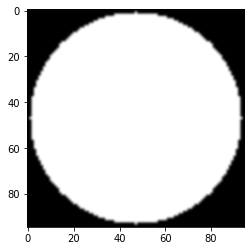

In [ ]:
#Template creation
template = np.ones((95,95), dtype="uint8") * 0
template = cv.circle(template, (47,47), 46, 255, -1)
print(template)
plt.imshow(template, cmap = 'gray', interpolation = 'bicubic')
template_path = ''
cv.imwrite(template_path, template)

In [ ]:
directory_path = ''#path where images are stored

In [ ]:
def getImage(img_num):
  path = 
  str_num = str(img_num)
  if (img_num) < 10:
    str_num = '0'+ str_num
  name = 'IDRiD_' + str_num + '.jpg'
  full_path = path + name
  image = cv.imread(full_path, -1)
  print(full_path)
  return image

In [ ]:
def imgResize(img):
  h = img.shape[0]
  w = img.shape[1]
  perc = 500/w
  w1 = 500
  h1 = int(h*perc)
  img_rs = cv.resize(img,(w1,h1))
  return img_rs

In [ ]:
def cannyEdges(img, th1, th2):
  edges = cv.Canny(img, th1, th2)
  return edges

In [ ]:
def kmeansclust(img, k):
  img_rsp = img.reshape((-1,1))
  img_rsp = img_rsp.astype('float32')
  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 400, 0.99)
  _, labels, (centers) = cv.kmeans(img_rsp, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
  centers = centers.astype('uint8')
  labels = labels.flatten()
  seg_img = centers[labels.flatten()]
  seg_img = seg_img.reshape(img.shape)
  return seg_img

In [ ]:
#Optic Disc Localization
i = 0
count = 0
start_time = time.time()
for img_num in range(1,55):
  img = getImage(img_num)
  print("Image Number: ", img_num)

  img_rs = imgResize(img)

  img_rc,_,_ = cv.split(img_rs)
  _,img_gc,_ = cv.split(img_rs)
  _,_,img_bc = cv.split(img_rs)
  img_grey = cv.cvtColor(img_rs, cv.COLOR_BGR2GRAY)


  img_k = kmeansclust(img_grey, 7)


  temp = cv.imread(template_path, -1)


  #TEMPLATE MATCHING
  metd = cv.TM_CCOEFF_NORMED
  temp_mat = cv.matchTemplate(img_k, temp, metd)

  min_val, max_val, min_loc, max_loc = cv.minMaxLoc(temp_mat)
  x = max_loc[0]+45
  y = max_loc[1]+45
  print(x,y)

  temp_mat = img_rc.copy()
  img_mark = cv.circle(temp_mat, (x, y) ,40, 0, -1)

  if (img_num<10):
    img_path = "/content/od_he/0" + str(img_num) +'.jpg'
  else:
    img_path = "/content/od_he/" + str(img_num) +'.jpg'
  cv.imwrite(img_path, img_mark)

  img_stack = np.hstack([img_mark, img_gc])

  plt.figure(img_num)
  plt.title(img_num)
  plt.imshow(img_stack, cmap = 'gray', interpolation = 'bicubic')


   
  i = i + 1

end_time = time.time()

#Hard Exudates

In [ ]:
def getContours1(img, img_main, cnt_area):
  mask1 = np.ones(img.shape, dtype="uint8") * 0	
  cnts0, hier0 = cv.findContours(img.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_NONE)
  for i in cnts0:
    if cv.contourArea(i) <= cnt_area:
      cv.drawContours(mask1, [i], -1, 255, -1)
  mask1 = cv.bitwise_and(img_main, img_main, mask = mask1)
  return mask1

In [ ]:
#Exudates Detection
acc = []
spcf = []
sens = []
f1_sc = []
i = 0
count = 0
img_num = 1
for img_num in range(1,55):
  if (img_num<10):
    str_num = "0" + str(img_num)
  else:
    str_num = str(img_num)
  file_path = "/content/od_he/" + str_num +'.jpg'
  img = cv.imread(file_path, -1)
  print("Image Number: ", img_num)

  
  clus_seg = kmeansclust(img, 15)
  unique, counts = np.unique(clus_seg, return_counts=True)
  _,kthm = cv.threshold(clus_seg, np.max(unique)-1, 255, cv.THRESH_BINARY)

  kthm = getContours1(kthm, kthm, 55)

  img_cnt = cv.dilate(edges, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)))
  img_clean = getContours1(img_cnt, img, 15)
  img_clean = cv.erode(img_clean, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), iterations=1)
  img_clean = cv.dilate(img_clean, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), iterations = 2)
  max_intsy = np.max(img_clean.flatten())
  img_clean[img_clean>=max_intsy] = 255
  img_clean[img_clean<max_intsy] = 0
  img_final = cv.bitwise_or(kthm, img_clean)
  unique, counts = np.unique(img_final, return_counts=True)
  print(dict(zip(unique, counts)))

  ex_stack = np.hstack([img, img_final])

  man_path = '' #path to groundtruth for side-by-side comparison
  img_he = cv.imread(man_path, 0)
  man = imgResize(img_he)
 
  _,man_th = cv.threshold(man,0 , 255, cv.THRESH_BINARY)
  
  ex_stack = np.hstack([img_final, man_th])

  plt.figure(img_num)
  plt.title(img_num)
  plt.imshow(ex_stack, cmap = 'gray', interpolation = 'bicubic')